In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
content_img_file = "pics\stanford.jpeg"
style_img_file = "style_pics\starry_night.jpeg"

In [3]:
max_dim = 512

### Load & Display images

In [4]:
def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape*scale, tf.int32)
    img = tf.image.resize(img, new_shape)
    img = np.expand_dims(img, axis=0)
    
    return img

In [5]:
def display_img(img, title=None):
    if (len(np.shape(img)) > 3):
        img = np.squeeze(img, axis=0)
    
    plt.imshow((img*255).astype(np.uint8))
    plt.axis("off")

    if (title): plt.title(title)

In [6]:
content_image = load_img(content_img_file)
style_image = load_img(style_img_file)

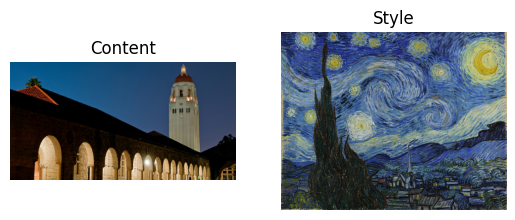

In [7]:
plt.subplot(1, 2, 1)
display_img(content_image, "Content")

plt.subplot(1, 2, 2)
display_img(style_image, "Style")

### Style, Content Extraction Model

In [8]:
vgg = tf.keras.applications.VGG16(include_top=False, weights="imagenet")
vgg.trainable = False

In [33]:
content_layer = 'block5_conv2'
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

In [34]:
def content_styel_model(content_layer, style_layers):
    inputs = vgg.input
    content_output = vgg.get_layer(content_layer).output
    style_outputs = [vgg.get_layer(layer).output for layer in style_layers]

    model = tf.keras.models.Model(inputs=inputs, outputs=[content_output, *style_outputs])
    return model

In [35]:
model = content_styel_model(content_layer, style_layers)

In [36]:
model.output

[<KerasTensor: shape=(None, None, None, 512) dtype=float32 (created by layer 'block5_conv2')>,
 <KerasTensor: shape=(None, None, None, 64) dtype=float32 (created by layer 'block1_conv1')>,
 <KerasTensor: shape=(None, None, None, 128) dtype=float32 (created by layer 'block2_conv1')>,
 <KerasTensor: shape=(None, None, None, 256) dtype=float32 (created by layer 'block3_conv1')>,
 <KerasTensor: shape=(None, None, None, 512) dtype=float32 (created by layer 'block4_conv1')>,
 <KerasTensor: shape=(None, None, None, 512) dtype=float32 (created by layer 'block5_conv1')>]

### Losses & Gram Matrix

#### Gram Matrix

![GRAM MATRIX](equations/gram%20matrix.png)

In [37]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum("bijc,bijd->bcd", input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    IJ = tf.cast(input_shape[1]*input_shape[2], tf.float32)

    return result / IJ

#### Content Loss

![CONTENT LOSS](equations/content%20loss.png)

In [38]:
def content_loss(content_features, content_traget):
    return tf.reduce_mean(tf.square(content_features - content_traget))

#### Style Loss

![STYLE LOSS](equations/style%20loss.png)

In [39]:
def style_loss(style_features, style_targets):
    loss = 0
    layer_weight = 1. / len(style_layers)
    for s, g in zip(style_features, style_targets):
        GS = gram_matrix(s)
        GG = gram_matrix(g)

        loss += tf.reduce_mean(tf.square(GS - GG))*layer_weight
    
    return loss

#### Variation Loss

In [40]:
def variation_loss(image):
    x_deltas = image[:, :, 1:, :] - image[:, :, :-1, :]
    y_deltas = image[:, 1:, :, :] - image[:, :-1, :, :]

    return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

### Training Model

In [41]:
vgg_preprocess = tf.keras.applications.vgg16.preprocess_input

In [42]:
content_target = model(vgg_preprocess(content_image*255))[0]
style_target = model(vgg_preprocess(style_image*255))[1:]

In [59]:
generated_image = tf.Variable(content_image, dtype=tf.float32)

#### Weights

In [60]:
c_weight = 5e3
s_weight = 1e-2
v_weight = 1e-3

#### Optimizer

In [61]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

#### Training Step

In [62]:
@tf.function
def train_step(generated_image):
    with tf.GradientTape() as tape:
        gen_img_features = model(vgg_preprocess(generated_image*255))
        gen_img_content = gen_img_features[0]
        gen_img_style = gen_img_features[1:]
        
        c_loss = content_loss(gen_img_content, content_target)
        s_loss = style_loss(gen_img_style, style_target)
        v_loss = variation_loss(generated_image)
        total_loss = c_weight*c_loss + s_weight*s_loss + v_weight*v_loss
    
    grads = tape.gradient(total_loss, generated_image)
    opt.apply_gradients([(grads, generated_image)])
    generated_image.assign(tf.clip_by_value(generated_image, clip_value_min=0.0, clip_value_max=1.0))
    

## Training

In [63]:
import IPython.display as display

In [64]:
epochs = 1000
for epoch in range(epochs):
    train_step(generated_image)

    print(f" ---- {epoch+1}/{epochs} Epochs ---- ", end="", flush=True)
    display.clear_output(wait=True)

 ---- 1000/1000 Epochs ---- 

### Show image

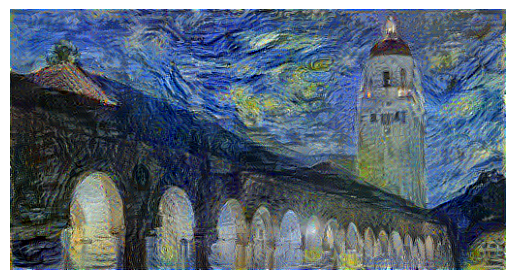

In [65]:
display_img(generated_image)

### Save image

In [50]:
def save_image(tensor_img, img_path="generated images/"):
    if (len(np.shape(tensor_img)) > 3):
        tensor_img = np.squeeze(tensor_img, axis=0)
    
    img = (tensor_img*255).astype(np.uint8)

    c = content_img_file.split("\\")[-1].split(".")[0]
    img_name = f"{img_path}{c}.jpg"
    
    tf.keras.utils.save_img(img_name, img)

In [51]:
save_image(generated_image)